# <b><u> Project Title : Taxi trip time Prediction : Predicting total ride duration of taxi trips in New York City</u></b>

## <b> Problem Description </b>

### Your task is to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

## <b> Data Description </b>

### The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this project. Based on individual trip attributes, you should predict the duration of each trip in the test set.

### <b>NYC Taxi Data.csv</b> - the training set (contains 1458644 trip records)


### Data fields
* #### id - a unique identifier for each trip
* #### vendor_id - a code indicating the provider associated with the trip record
* #### pickup_datetime - date and time when the meter was engaged
* #### dropoff_datetime - date and time when the meter was disengaged
* #### passenger_count - the number of passengers in the vehicle (driver entered value)
* #### pickup_longitude - the longitude where the meter was engaged
* #### pickup_latitude - the latitude where the meter was engaged
* #### dropoff_longitude - the longitude where the meter was disengaged
* #### dropoff_latitude - the latitude where the meter was disengaged
* #### store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* #### trip_duration - duration of the trip in seconds

In [ ]:
import numpy as np
import pandas as pd
from numpy import math
from geopy.distance import great_circle
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
working_dir_path= "/content/drive/MyDrive/NYC Taxi Data.csv"
data= pd.read_csv(working_dir_path)

In [ ]:
working_path= "/content/drive/MyDrive/nybb.csv"
boundary= pd.read_csv(working_path)

# **Data Exploration**

In [ ]:
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


Pickup_datetime and dropoff_datetime are both objects. Hence it should be converted to datetime to run functions if and when necessary

In [ ]:
data.shape

(1458644, 11)

In [ ]:
print("There are %d unique id's in Training dataset, which is equal to the number of records"%(data.id.nunique()))

There are 1458644 unique id's in Training dataset, which is equal to the number of records


In [ ]:
data.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [ ]:
data['pickup_datetime']=pd.to_datetime(data['pickup_datetime'])
data['dropoff_datetime']=pd.to_datetime(data['dropoff_datetime'])

In [ ]:
#extraction for detailed analysis
data['up_weekday'] = data.pickup_datetime.dt.day_name()
data['up_month'] = data.pickup_datetime.dt.month
data['pickup_hour'] = data.pickup_datetime.dt.hour
data['off_weekday'] = data.dropoff_datetime.dt.day_name()
data['off_month'] = data.dropoff_datetime.dt.month
data['dropoff_hour'] = data.dropoff_datetime.dt.hour

In [ ]:
#distance calculation function
def cal_distance(up_lat,up_long,off_lat,off_long):
 start=(up_lat,up_long)
 stop=(off_lat,off_long)
 return great_circle(start,stop).km

In [ ]:
data['distance'] = data.apply(lambda x: cal_distance(x['pickup_latitude'],x['pickup_longitude'],x['dropoff_latitude'],x['dropoff_longitude']),axis=1)

In [ ]:
#putting location co-ordinates for pickup and dropoff in two separate columns only
def coords(latitude,longitude):
  return [latitude,longitude] 

In [ ]:
data['pickup']= data.apply(lambda y: coords(y['pickup_latitude'],y['pickup_longitude']),axis=1)

In [ ]:
data['dropoff']= data.apply(lambda z: coords(z['dropoff_latitude'],z['dropoff_longitude']),axis=1)

In [ ]:
data.passenger_count.value_counts()

1    1033540
2     210318
5      78088
3      59896
6      48333
4      28404
0         60
7          3
9          1
8          1
Name: passenger_count, dtype: int64

In [ ]:
#too less freq of 0,7,8,9 number of passengers, hence dropping outliers
data=data[data.passenger_count<=6]
data=data[data.passenger_count!=0]

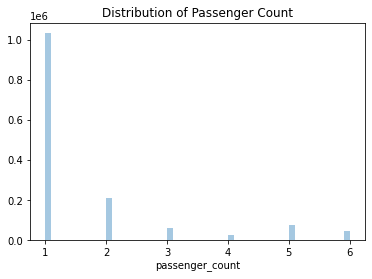

In [ ]:
sns.distplot(data['passenger_count'],kde=False)
plt.title('Distribution of Passenger Count')
plt.show()

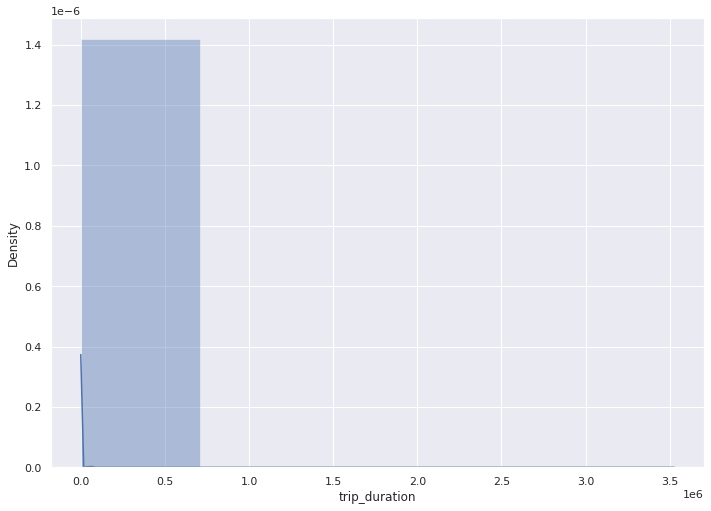

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.distplot(data['trip_duration'], bins=5)
plt.show()

In [ ]:
data['duration']= data['trip_duration']/3600

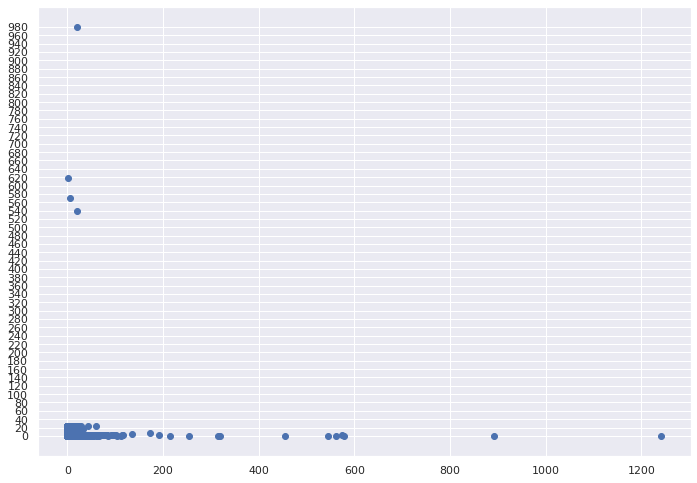

In [ ]:
# distance- duration plotting
plt.yticks(ticks = np.arange(0, 1000, 20))
plt.scatter(x = data['distance'], y=data['duration'])
plt.show()

**EXTENSIVE OUTLIERS**

Extensive outliers, which are need to be eliminated as a few trips were continued for above 200 hours, which is a highly unlikely data and can easily bring about problems during regression

In [ ]:
#checking duration recorded over 100 hours
o=len(data[data.duration>=100])
o

4

In [ ]:
#throwing away impossible rides
index_imp = data[ data['duration'] >= 100 ].index
data.drop(index_imp, inplace = True)

In [ ]:
#checking the rest of the data, especially trips that took over 5 hours; a city ride above 5 hours does sound fishy
ox=len(data[data.duration>=5])
ox

2067

In [ ]:
#extracting such data to check plausibility 
k= data.loc[data['duration']>=5]
k

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,up_weekday,up_month,pickup_hour,off_weekday,off_month,dropoff_hour,distance,pickup,dropoff,duration
531,id3307903,2,2016-02-20 04:03:06,2016-02-21 03:33:00,3,-74.008102,40.741489,-74.009956,40.714611,N,84594,Saturday,2,4,Sunday,2,3,2.992821,"[40.74148941040039, -74.00810241699219]","[40.7146110534668, -74.00995635986328]",23.498333
1134,id1091477,2,2016-05-07 18:36:22,2016-05-08 18:32:11,1,-73.990242,40.750919,-73.976280,40.750889,N,86149,Saturday,5,18,Sunday,5,18,1.176095,"[40.750919342041016, -73.99024200439453]","[40.75088882446289, -73.97628021240234]",23.930278
1865,id3431345,2,2016-06-07 12:58:48,2016-06-08 12:58:00,6,-73.954956,40.777649,-73.981033,40.743713,N,86352,Tuesday,6,12,Wednesday,6,12,4.366110,"[40.77764892578125, -73.9549560546875]","[40.74371337890625, -73.98103332519531]",23.986667
3442,id1487069,2,2016-02-13 00:21:49,2016-02-14 00:19:05,1,-73.968590,40.799217,-73.979584,40.784714,N,86236,Saturday,2,0,Sunday,2,0,1.859418,"[40.799217224121094, -73.96858978271484]","[40.78471374511719, -73.97958374023438]",23.954444
4172,id3674870,2,2016-03-18 11:54:20,2016-03-19 11:34:17,1,-73.989090,40.736992,-73.972336,40.751511,N,85197,Friday,3,11,Saturday,3,11,2.144415,"[40.73699188232422, -73.9890899658203]","[40.75151062011719, -73.97233581542969]",23.665833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455097,id2798196,2,2016-03-20 03:51:36,2016-03-21 00:00:00,2,-73.969299,40.757301,-73.870277,40.709808,N,72504,Sunday,3,3,Monday,3,0,9.874283,"[40.757301330566406, -73.96929931640625]","[40.709808349609375, -73.87027740478516]",20.140000
1456458,id2055880,2,2016-02-08 19:11:31,2016-02-09 19:08:44,3,-73.973282,40.760792,-73.988518,40.764210,N,86233,Monday,2,19,Tuesday,2,19,1.338294,"[40.76079177856445, -73.97328186035155]","[40.76420974731445, -73.98851776123048]",23.953611
1457207,id1910950,2,2016-06-08 16:29:12,2016-06-09 16:11:03,1,-73.958061,40.800869,-73.964119,40.805515,N,85311,Wednesday,6,16,Thursday,6,16,0.725879,"[40.80086898803711, -73.95806121826173]","[40.80551528930664, -73.96411895751955]",23.697500
1457752,id1215198,2,2016-02-02 11:31:10,2016-02-03 11:29:44,6,-73.972069,40.794220,-73.961014,40.806728,N,86314,Tuesday,2,11,Wednesday,2,11,1.673447,"[40.79421997070313, -73.9720687866211]","[40.80672836303711, -73.96101379394531]",23.976111


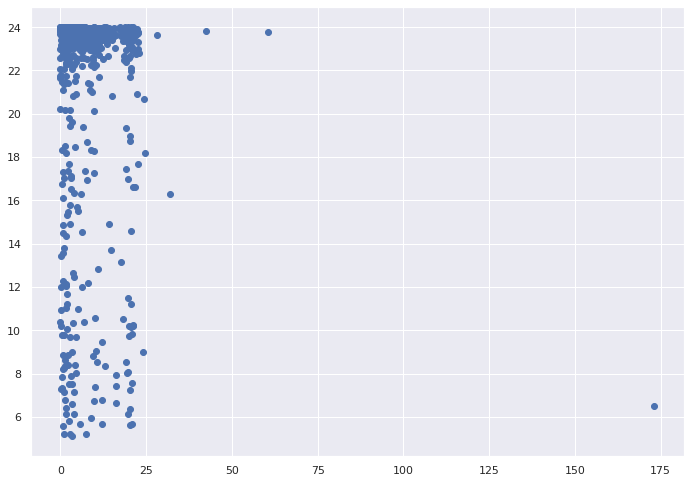

In [ ]:
df1 = k[['distance','duration']]
plt.yticks(ticks = np.arange(0, 30, 2))
plt.scatter(x = df1['distance'], y=df1['duration'])
plt.show()

The duration vs distance in the data shows that such data is highly implausible, and hence should be eliminated to prepare the model for training

In [ ]:
#dropping cancelled rides which cannot determine trip duration
index_zero_dist = data[ data['distance'] == 0 ].index
data.drop(index_zero_dist, inplace = True)

In [ ]:
#checking number of distance recorded over 200
p=len(data[data.distance>=200])
p

11

In [ ]:
#extracting their rows to check the data
f= data.loc[data['distance']>=200]
f

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,up_weekday,up_month,pickup_hour,off_weekday,off_month,dropoff_hour,distance,pickup,dropoff,duration
184925,id2306955,1,2016-05-07 18:58:53,2016-05-07 19:12:05,1,-72.809669,51.881084,-73.987228,40.750599,N,792,Saturday,5,18,Saturday,5,19,1240.910430,"[51.88108444213867, -72.8096694946289]","[40.7505989074707, -73.98722839355469]",0.220000
275644,id0978162,1,2016-02-24 16:20:59,2016-02-24 16:35:34,4,-75.354332,34.712234,-73.834923,32.181141,N,875,Wednesday,2,16,Wednesday,2,16,314.764648,"[34.71223449707032, -75.35433197021484]","[32.1811408996582, -73.83492279052734]",0.243056
377068,id0116374,1,2016-04-02 20:33:19,2016-04-02 20:38:01,1,-74.007095,40.717113,-76.963242,38.946033,N,282,Saturday,4,20,Saturday,4,20,320.126227,"[40.71711349487305, -74.00709533691406]","[38.9460334777832, -76.96324157714844]",0.078333
397526,id0982904,1,2016-04-28 13:32:14,2016-04-28 14:14:09,2,-73.870682,40.773598,-79.817978,38.963852,N,2515,Thursday,4,13,Thursday,4,14,545.854270,"[40.773597717285156, -73.87068176269531]","[38.96385192871094, -79.81797790527342]",0.698611
644165,id0401529,2,2016-06-02 15:19:35,2016-06-02 15:32:59,1,-73.980751,40.757111,-74.240051,38.478298,N,804,Thursday,6,15,Thursday,6,15,254.363882,"[40.75711059570313, -73.98075103759766]","[38.47829818725585, -74.24005126953125]",0.223333
910072,id1146400,1,2016-02-15 18:57:32,2016-02-15 19:02:35,2,-73.989914,40.756634,-70.346077,36.398121,N,303,Monday,2,18,Monday,2,19,578.843635,"[40.75663375854492, -73.98991394042969]","[36.39812088012695, -70.34607696533203]",0.084167
923793,id1001696,1,2016-02-24 21:02:32,2016-02-24 21:25:57,1,-73.972366,40.758633,-79.553535,43.674000,N,1405,Wednesday,2,21,Wednesday,2,21,562.235982,"[40.7586326599121, -73.97236633300781]","[43.67399978637695, -79.55353546142578]",0.390278
974378,id1510552,2,2016-01-06 20:40:52,2016-01-06 20:51:03,5,-71.799896,35.081532,-79.352837,40.436329,N,611,Wednesday,1,20,Wednesday,1,20,891.215362,"[35.0815315246582, -71.79989624023438]","[40.43632888793945, -79.35283660888672]",0.169722
1013474,id3626673,1,2016-05-05 18:02:50,2016-05-05 18:18:23,1,-73.978912,40.756763,-79.338699,41.427902,N,933,Thursday,5,18,Thursday,5,18,455.241847,"[40.75676345825195, -73.97891235351562]","[41.42790222167969, -79.3386993408203]",0.259167
1060807,id0838705,1,2016-02-26 19:50:03,2016-02-26 20:08:54,1,-66.972160,44.371944,-69.048019,43.147583,N,1131,Friday,2,19,Friday,2,20,215.226877,"[44.37194442749024, -66.97216033935545]","[43.1475830078125, -69.04801940917969]",0.314167


In [ ]:
#dropping impossible rides which cannot determine trip duration
index_imp_dist = data[ data['distance'] >= 200 ].index
data.drop(index_imp_dist, inplace = True)

In [ ]:
#dropping rides which are implausible, and takes over 5 hours to complete
index_imp_dura = data[data['duration'] >=5].index
data.drop(index_imp_dura, inplace= True)

Interestingly, the legal speed limit to drive a taxi within NYC is 25 miles per hour, which is roughly 41 km per hour. Hence, let us try to check speed of taxi trips that have covered distances above 41 km, because the fine for getting caught for overspeeding is considerably high, and is not something that taxi drivers would be risking for a marginal tip from passengers.

In [ ]:
def speednyc(x,y):
  return x/y

In [ ]:
data['speed']= data.apply(lambda x:speednyc(x['distance'],x['duration']),axis=1)

In [ ]:
#checking number of speed recorded over 40
num=len(data[data.speed>=40])
num

16357

we need to eliminate this kind of data because this is kind of inconsitent, illegal and should not be a primary part of observing how overspeeding might have affected trip time.

In [ ]:
#throwing away rides with overspeeding as it isnt a regular or economical or legal way to account for rides
index_imp_speed = data[ data['speed'] >= 40 ].index
data.drop(index_imp_speed, inplace = True)

In [ ]:
#throwing away the column speed as it will cause irregularity in modelling, because its a function of duration itself; and trip duration as duration points out time in hours, also dropping out pickup and dropoff latitude, longitudes, pickup and dropoff date times, and the id of each taxi driver
data.drop(['speed','id','trip_duration','pickup_datetime','dropoff_datetime'],axis=1)

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,up_weekday,up_month,pickup_hour,off_weekday,off_month,dropoff_hour,distance,pickup,dropoff,duration
0,2,1,-73.982155,40.767937,-73.964630,40.765602,N,Monday,3,17,Monday,3,17,1.498523,"[40.76793670654297, -73.98215484619139]","[40.765602111816406, -73.96463012695312]",0.126389
1,1,1,-73.980415,40.738564,-73.999481,40.731152,N,Sunday,6,0,Sunday,6,0,1.805510,"[40.738563537597656, -73.98041534423827]","[40.73115158081055, -73.99948120117188]",0.184167
2,2,1,-73.979027,40.763939,-74.005333,40.710087,N,Tuesday,1,11,Tuesday,1,12,6.385108,"[40.763938903808594, -73.97902679443358]","[40.71008682250977, -74.00533294677734]",0.590000
3,2,1,-74.010040,40.719971,-74.012268,40.706718,N,Wednesday,4,19,Wednesday,4,19,1.485501,"[40.719970703125, -74.01004028320312]","[40.70671844482422, -74.01226806640625]",0.119167
4,2,1,-73.973053,40.793209,-73.972923,40.782520,N,Saturday,3,13,Saturday,3,13,1.188590,"[40.79320907592773, -73.97305297851562]","[40.78252029418945, -73.9729232788086]",0.120833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,2,4,-73.982201,40.745522,-73.994911,40.740170,N,Friday,4,13,Friday,4,13,1.225082,"[40.745521545410156, -73.9822006225586]","[40.74016952514648, -73.99491119384766]",0.216111
1458640,1,1,-74.000946,40.747379,-73.970184,40.796547,N,Sunday,1,7,Sunday,1,7,6.049844,"[40.74737930297852, -74.00094604492188]","[40.796546936035156, -73.97018432617188]",0.181944
1458641,2,1,-73.959129,40.768799,-74.004433,40.707371,N,Friday,4,6,Friday,4,7,7.824617,"[40.768798828125, -73.9591293334961]","[40.70737075805664, -74.00443267822266]",0.212222
1458642,1,1,-73.982079,40.749062,-73.974632,40.757107,N,Tuesday,1,15,Tuesday,1,16,1.092565,"[40.749061584472656, -73.9820785522461]","[40.75710678100585, -73.97463226318358]",0.103611


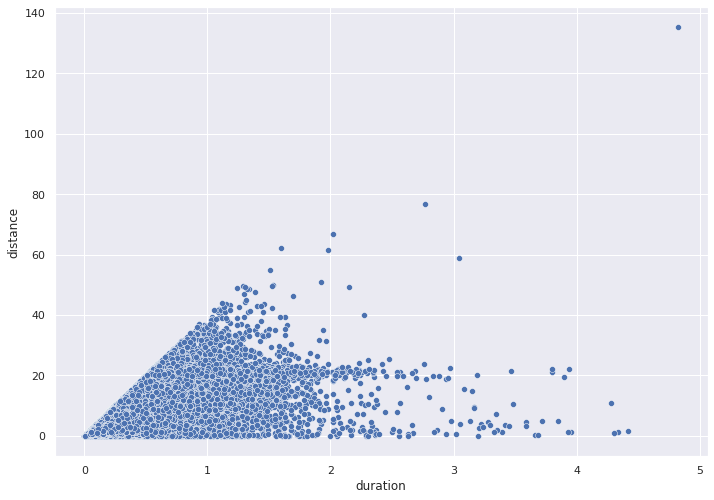

In [ ]:
sns.scatterplot(x='duration',y='distance',data=data)

Lets divide the pickup and dropoff locations into boroughs, so that we can understand if there's any relation between the pickup and drop off locations. We could have used Reverse Geocoding for this step, but the problem is such that we have a few million pair of coordinates to Reverse Geocode, so this might not be an optimal solution. Instead, we go ahead by using a shape file, which contains boundaries of the boroughs, in which the pickup and dropoff locations

**YEAH, FOR FUCK'S SAKE I CAN'T MAKE IT HAPPEN FOR A 1000 REASONS, SO I'LL INSTEAD BIN THE FUCKERS**

In [ ]:
boundary

,BoroName,BoroCode,Shape_Leng,the_geom,Shape_Area
0,Manhattan,1,361611.823950,MULTIPOLYGON (((-74.01092841268026 40.68449147...,6.366038e+08
1,Bronx,2,464650.051807,MULTIPOLYGON (((-73.89680883223774 40.79580844...,1.187245e+09
2,Brooklyn,3,729592.941749,MULTIPOLYGON (((-73.86706149472118 40.58208797...,1.934091e+09
3,Queens,4,900087.667191,MULTIPOLYGON (((-73.8264466151686 40.590527442...,3.044042e+09
4,Staten Island,5,325956.009000,MULTIPOLYGON (((-74.05050806403247 40.56642203...,1.623757e+09


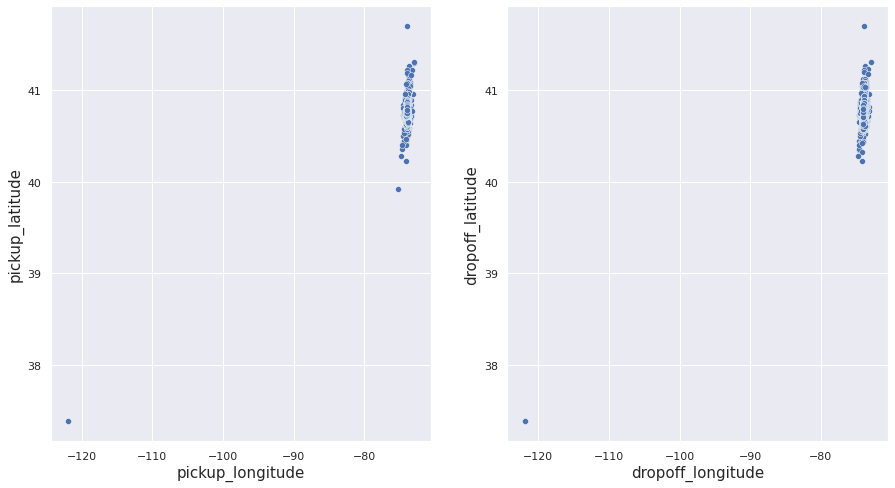

In [ ]:
f,ax = plt.subplots(1, 2, figsize = (15, 8))
sns.scatterplot(data["pickup_longitude"], data["pickup_latitude"], ax=ax[0])
ax[0].set_xlabel("pickup_longitude", fontsize = 15)
ax[0].set_ylabel("pickup_latitude", fontsize = 15)
sns.scatterplot(data["dropoff_longitude"], data["dropoff_latitude"], ax=ax[1])
ax[1].set_xlabel("dropoff_longitude", fontsize = 15)
ax[1].set_ylabel("dropoff_latitude", fontsize = 15)

plt.show()

# **IMPORTANT OBSERVATIONS:**
1. Now we have a slightly smaller dataset, to deal with; and the strongest outliers and incredible/useless rows of data are eliminated
2. There are still figures that seem to far fetched as numbers when taken into consideration that its a city ride, but we try to build our model taking into account these points too, but this could be a valid checkpoint if our model dont perform well. They might need special treatment, but they stay as of now.


In [ ]:
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,up_weekday,up_month,pickup_hour,off_weekday,off_month,dropoff_hour,distance,duration,speed
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,Monday,3,17,Monday,3,17,1.498523,0.126389,11.856445
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,Sunday,6,0,Sunday,6,0,1.805510,0.184167,9.803673
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,Tuesday,1,11,Tuesday,1,12,6.385108,0.590000,10.822216
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,Wednesday,4,19,Wednesday,4,19,1.485501,0.119167,12.465739
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,Saturday,3,13,Saturday,3,13,1.188590,0.120833,9.836608


In [ ]:
# encoding timezones of the day into broad categories
def timezone(x):
    if x>= 0 and x <= 6:
        return 1
    elif x>= 7 and x <= 12:
        return 2
    elif x>= 13 and x <= 18:
        return 3
    elif x>= 19 and x <=24:
        return 4

In [ ]:
data['up_slot'] = data.apply(lambda y: timezone(y['pickup_hour']),axis=1)
data['off_slot'] = data.apply(lambda y: timezone(y['dropoff_hour']),axis=1)

In [ ]:
p= data.loc[data['up_slot']!=data['off_slot']]
p.shape

(60657, 22)

In [ ]:
#encoding months into 4 broad quarters
def quarter(i):
    if i>= 0 and i <= 3:
        return 1
    elif i>= 4 and i <= 6 :
        return 2
    elif i>= 7 and i <= 9:
        return 3
    elif i>= 10 and i <=12:
        return 4

In [ ]:
data['up_quarter'] = data.apply(lambda y: quarter(y['up_month']),axis=1)
data['off_quarter'] = data.apply(lambda y: quarter(y['off_month']),axis=1)

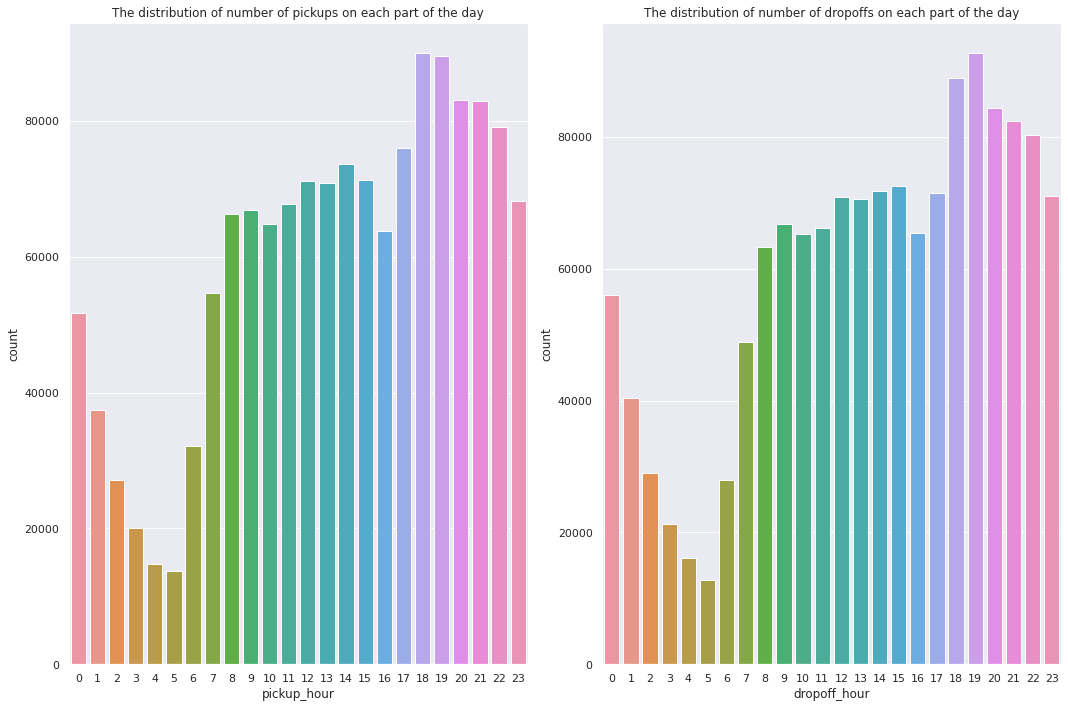

In [ ]:
#distribution of pickups and dropoffs
figure,ax=plt.subplots(nrows=1,ncols=2,figsize=(15,10))
sns.countplot(x='pickup_hour',data=data,ax=ax[0])
ax[0].set_title('The distribution of number of pickups on each part of the day')
sns.countplot(x='dropoff_hour',data=data,ax=ax[1])
ax[1].set_title('The distribution of number of dropoffs on each part of the day')
plt.tight_layout()

Text(0.5, 1.0, 'The Average Trip Duration per Dropoff Day of the week')

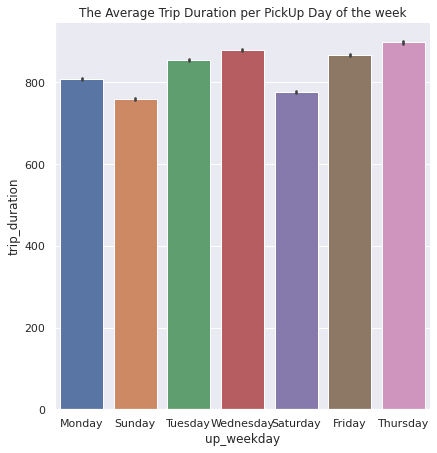

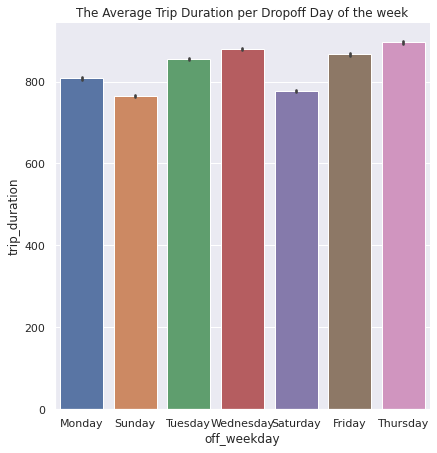

In [ ]:
#distribution of trip duration and day of the week
sns.catplot(x="up_weekday",y="trip_duration",kind="bar",data=data,height=6,aspect=1)
plt.title('The Average Trip Duration per PickUp Day of the week')
sns.catplot(x="off_weekday",y="trip_duration",kind="bar",data=data,height=6,aspect=1)
plt.title('The Average Trip Duration per Dropoff Day of the week')


*The highest avg time taken to complete a trip is on Friday while Monday, Saturday and Sunday takes the least time.*

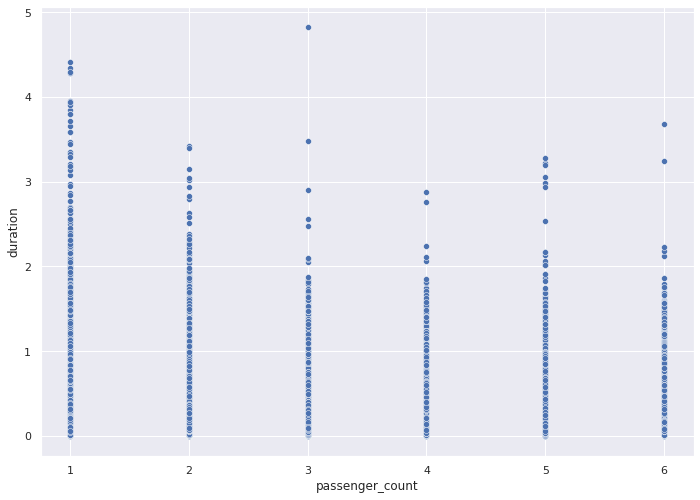

In [ ]:
#passenger count and trip duration hours
sns.scatterplot(x="passenger_count", y="duration", data=data)

# **Modelling**

In [ ]:
data.head()

In [ ]:
# Encode categorical variables of store_n_fwd_flag
def flg(b):
  if b=='Y':
    return 1
  else:
    return 0

In [ ]:
data['flag'] = data.apply(lambda y: flg(y['store_and_fwd_flag']),axis=1)
data.head()

In [ ]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
newdf = data.select_dtypes(include=numerics)

In [ ]:
x= newdf.columns
x

In [ ]:
#correlation heatmap
plt.figure(figsize=(20, 15))
heatmap = sns.heatmap(newdf.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

This shows theres no strong correlation between any of the features and the target variable: duration. Hence, we opt for Backward Elimation technique to determine feature importance, using OLS Model

**Linear Regression**

In [ ]:
newdf.head()


In [ ]:
newdf.drop(['trip_duration','up_month','off_month','pickup_hour','dropoff_hour'],axis=1)

In [ ]:
features= newdf
features.head()

In [ ]:
x1 = newdf[['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude','dropoff_longitude', 'dropoff_latitude','distance','up_slot', 'off_slot', 'up_quarter', 'off_quarter', 'flag']]
#scaled x
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
x = scaler.fit_transform(x1)
y = newdf['duration']

In [ ]:
# Splitting the dataset into training and test set.  
x_train, x_test, y_train, y_test= train_test_split(x, y, test_size= 0.3, random_state=0)  

#  Instantiate model object
reg = LinearRegression()

# Fit to training data
reg.fit(x_train,y_train)

# Predict
y_pred = reg.predict(x_test)

#checking scores
print('Train Score: ', reg.score(x_train, y_train))  
print('Test Score: ', reg.score(x_test, y_test))  

Train Score:  0.008404171353792678
Test Score:  0.022097937743520424


Apart from the score difference, we see how they reflect the fact that there has been no such strong correlation between features. Hence we try to understand the model using Backward Elimination Technique

**FEATURE SELECTION**

In [ ]:
def backward_elimination(data, target,significance_level = 0.05):
    features = data.columns.tolist()
    while(len(features)>0):
        features_with_constant = sm.add_constant(data[features])
        p_values = sm.OLS(target, features_with_constant).fit().pvalues[1:]
        max_p_value = p_values.max()
        if(max_p_value >= significance_level):
            excluded_feature = p_values.idxmax()
            features.remove(excluded_feature)
        else:
            break 
    return features

In [ ]:
backward_elimination(newdf,y,0.05)

['vendor_id', 'dropoff_latitude', 'trip_duration', 'distance', 'duration']

In [ ]:
import statsmodels.regression.linear_model as sm
# add a column of ones as integer data type
x = np.append(arr = np.ones((1452692, 1)).astype(int), 
              values = x, axis = 1)
# choose a Significance level usually 0.05, if p>0.05
#  for the highest values parameter, remove that value
x_opt = x[:, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]]
ols = sm.OLS(endog = y, exog = x_opt).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               duration   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     1223.
Date:                Mon, 26 Apr 2021   Prob (F-statistic):               0.00
Time:                        03:27:13   Log-Likelihood:            -2.6010e+06
No. Observations:             1452692   AIC:                         5.202e+06
Df Residuals:                 1452679   BIC:                         5.202e+06
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2948      0.931     -0.317      0.752      -2.120       1.530
x1             0.0554      0.003     21.948      0.000       0.050       0.060
x2             0.0111      0.005      2.313      0.021       0.002       0.020
x3             0.4932      1.566      0.315      0.753      -2.577       3.563
x4            -7.3395      0.759     -9.675      0.000      -8.826      -5.853
x5             4.7789      1.481      3.226      0.001       1.875       7.683
x6            -2.4344      0.464     -5.249      0.000      -3.343      -1.525
x7            38.1831      0.375    101.861      0.000      37.448      38.918
x8            -0.0101      0.011     -0.951      0.342      -0.031       0.011
x9             0.0295      0.010      2.815      0.005       0.009       0.050
x10           -2.4852      0.094    -26.356      0.000      -2.670      -2.300
x11            4.9991      0.189     26.517      0.000       4.630       5.369
x12            0.0148      0.016      0.907      0.364      -0.017       0.047
================================================================================
Omnibus:                  8279630.478   Durbin-Watson:                     2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   2306225536012102.500
Skew:                         347.564   Prob(JB):                           0.00
Kurtosis:                  195197.233   Cond. No.                       3.62e+03
================================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.62e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We see that the highest value of P is 0.785, hence, we throw out x3 as it has highest value

In [ ]:
# remove the 3rd column as it has the highest value
x_opt = x[:, [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12]]
ols = sm.OLS(endog = y, exog = x_opt).fit()
ols.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               duration   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     1335.
Date:                Mon, 26 Apr 2021   Prob (F-statistic):               0.00
Time:                        03:27:14   Log-Likelihood:            -2.6010e+06
No. Observations:             1452692   AIC:                         5.202e+06
Df Residuals:                 1452680   BIC:                         5.202e+06
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1888      0.868     -0.217      0.828      -1.890       1.513
x1             0.0554      0.003     21.951      0.000       0.050       0.060
x2             0.0111      0.005      2.313      0.021       0.002       0.020
x3            -7.3583      0.756     -9.730      0.000      -8.840      -5.876
x4             5.1336      0.962      5.336      0.000       3.248       7.019
x5            -2.4219      0.462     -5.241      0.000      -3.328      -1.516
x6            38.2121      0.363    105.163      0.000      37.500      38.924
x7            -0.0101      0.011     -0.952      0.341      -0.031       0.011
x8             0.0296      0.010      2.822      0.005       0.009       0.050
x9            -2.4852      0.094    -26.356      0.000      -2.670      -2.300
x10            4.9990      0.189     26.516      0.000       4.630       5.369
x11            0.0148      0.016      0.907      0.364      -0.017       0.047
================================================================================
Omnibus:                  8279637.358   Durbin-Watson:                     2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   2306245888206206.500
Skew:                         347.565   Prob(JB):                           0.00
Kurtosis:                  195198.095   Cond. No.                       2.08e+03
================================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.08e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
# remove the 0th column as it has the highest value
x_opt = x[:, [1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12]]
ols = sm.OLS(endog = y, exog = x_opt).fit()
ols.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               duration   R-squared (uncentered):                   0.042
Model:                            OLS   Adj. R-squared (uncentered):              0.042
Method:                 Least Squares   F-statistic:                              5813.
Date:                Mon, 26 Apr 2021   Prob (F-statistic):                        0.00
Time:                        03:27:15   Log-Likelihood:                     -2.6010e+06
No. Observations:             1452692   AIC:                                  5.202e+06
Df Residuals:                 1452681   BIC:                                  5.202e+06
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0554      0.003     21.952      0.000       0.050       0.060
x2             0.0111      0.005      2.312      0.021       0.002       0.020
x3            -7.3636      0.756     -9.742      0.000      -8.845      -5.882
x4             4.9400      0.364     13.564      0.000       4.226       5.654
x5            -2.4374      0.457     -5.339      0.000      -3.332      -1.543
x6            38.2195      0.362    105.649      0.000      37.511      38.929
x7            -0.0101      0.011     -0.953      0.341      -0.031       0.011
x8             0.0296      0.010      2.821      0.005       0.009       0.050
x9            -2.4852      0.094    -26.356      0.000      -2.670      -2.300
x10            4.9991      0.189     26.516      0.000       4.630       5.369
x11            0.0148      0.016      0.908      0.364      -0.017       0.047
================================================================================
Omnibus:                  8279636.185   Durbin-Watson:                     2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   2306243117193600.500
Skew:                         347.565   Prob(JB):                           0.00
Kurtosis:                  195197.977   Cond. No.                       1.13e+03
================================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
# remove the 11th column as it has the highest value
x_opt = x[:, [1, 2, 4, 5, 6, 7, 8, 9, 10, 12]]
ols = sm.OLS(endog = y, exog = x_opt).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               duration   R-squared (uncentered):                   0.042
Model:                            OLS   Adj. R-squared (uncentered):              0.042
Method:                 Least Squares   F-statistic:                              6321.
Date:                Mon, 26 Apr 2021   Prob (F-statistic):                        0.00
Time:                        03:27:16   Log-Likelihood:                     -2.6013e+06
No. Observations:             1452692   AIC:                                  5.203e+06
Df Residuals:                 1452682   BIC:                                  5.203e+06
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0554      0.003     21.939      0.000       0.050       0.060
x2             0.0110      0.005      2.295      0.022       0.002       0.020
x3            -7.3565      0.756     -9.731      0.000      -8.838      -5.875
x4             4.9528      0.364     13.596      0.000       4.239       5.667
x5            -2.4564      0.457     -5.379      0.000      -3.351      -1.561
x6            38.3035      0.362    105.860      0.000      37.594      39.013
x7             0.0171      0.011      1.623      0.105      -0.004       0.038
x8             0.0024      0.010      0.233      0.816      -0.018       0.023
x9             0.0143      0.002      5.955      0.000       0.010       0.019
x10            0.0144      0.016      0.879      0.379      -0.018       0.046
================================================================================
Omnibus:                  8278127.709   Durbin-Watson:                     2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   2301637517807696.500
Skew:                         347.326   Prob(JB):                           0.00
Kurtosis:                  195002.976   Cond. No.                       1.11e+03
================================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.11e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
# remove the 8th column as it has the highest value
x_opt = x[:, [1, 2, 4, 5, 6, 7, 9, 10, 11, 12]]
ols = sm.OLS(endog = y, exog = x_opt).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               duration   R-squared (uncentered):                   0.042
Model:                            OLS   Adj. R-squared (uncentered):              0.042
Method:                 Least Squares   F-statistic:                              6394.
Date:                Mon, 26 Apr 2021   Prob (F-statistic):                        0.00
Time:                        03:27:18   Log-Likelihood:                     -2.6010e+06
No. Observations:             1452692   AIC:                                  5.202e+06
Df Residuals:                 1452682   BIC:                                  5.202e+06
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0554      0.003     21.952      0.000       0.050       0.060
x2             0.0110      0.005      2.309      0.021       0.002       0.020
x3            -7.3532      0.756     -9.730      0.000      -8.834      -5.872
x4             4.9359      0.364     13.554      0.000       4.222       5.650
x5            -2.4378      0.457     -5.340      0.000      -3.333      -1.543
x6            38.2187      0.362    105.647      0.000      37.510      38.928
x7             0.0202      0.004      5.749      0.000       0.013       0.027
x8            -2.4765      0.094    -26.387      0.000      -2.660      -2.293
x9             4.9817      0.188     26.549      0.000       4.614       5.349
x10            0.0149      0.016      0.909      0.363      -0.017       0.047
================================================================================
Omnibus:                  8279620.733   Durbin-Watson:                     2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   2306191195834179.500
Skew:                         347.562   Prob(JB):                           0.00
Kurtosis:                  195195.780   Cond. No.                       1.05e+03
================================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.05e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
# remove the 10th column as it has the highest value
x_opt = x[:, [1, 2, 4, 5, 6, 7, 9, 11, 12]]
ols = sm.OLS(endog = y, exog = x_opt).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               duration   R-squared (uncentered):                   0.042
Model:                            OLS   Adj. R-squared (uncentered):              0.042
Method:                 Least Squares   F-statistic:                              7023.
Date:                Mon, 26 Apr 2021   Prob (F-statistic):                        0.00
Time:                        03:27:19   Log-Likelihood:                     -2.6013e+06
No. Observations:             1452692   AIC:                                  5.203e+06
Df Residuals:                 1452683   BIC:                                  5.203e+06
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0554      0.003     21.943      0.000       0.050       0.060
x2             0.0110      0.005      2.301      0.021       0.002       0.020
x3            -7.3741      0.756     -9.755      0.000      -8.856      -5.892
x4             4.9592      0.364     13.615      0.000       4.245       5.673
x5            -2.4563      0.457     -5.379      0.000      -3.351      -1.561
x6            38.3015      0.362    105.855      0.000      37.592      39.011
x7             0.0184      0.004      5.249      0.000       0.012       0.025
x8             0.0319      0.005      6.636      0.000       0.023       0.041
x9             0.0143      0.016      0.877      0.381      -0.018       0.046
================================================================================
Omnibus:                  8278170.653   Durbin-Watson:                     2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   2301772173122145.000
Skew:                         347.333   Prob(JB):                           0.00
Kurtosis:                  195008.680   Cond. No.                           991.
================================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# remove the 9th column as it has the highest value
x_opt = x[:, [1, 2, 4, 5, 6, 7, 11, 12]]
ols = sm.OLS(endog = y, exog = x_opt).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               duration   R-squared (uncentered):                   0.042
Model:                            OLS   Adj. R-squared (uncentered):              0.042
Method:                 Least Squares   F-statistic:                              7898.
Date:                Mon, 26 Apr 2021   Prob (F-statistic):                        0.00
Time:                        03:27:20   Log-Likelihood:                     -2.6014e+06
No. Observations:             1452692   AIC:                                  5.203e+06
Df Residuals:                 1452684   BIC:                                  5.203e+06
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0555      0.003     21.979      0.000       0.051       0.060
x2             0.0112      0.005      2.337      0.019       0.002       0.021
x3            -7.3510      0.756     -9.725      0.000      -8.833      -5.869
x4             4.9314      0.364     13.540      0.000       4.218       5.645
x5            -2.4182      0.457     -5.296      0.000      -3.313      -1.523
x6            38.2746      0.362    105.790      0.000      37.566      38.984
x7             0.0318      0.005      6.608      0.000       0.022       0.041
x8             0.0147      0.016      0.897      0.370      -0.017       0.047
================================================================================
Omnibus:                  8278097.345   Durbin-Watson:                     2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   2301586488422956.500
Skew:                         347.321   Prob(JB):                           0.00
Kurtosis:                  195000.814   Cond. No.                           912.
================================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

All features that should be eliminated are done, hence now we need to fit our model and make Predictions

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(x_opt,y,test_size=0.3,random_state=0)
new_model=LinearRegression()
new_model.fit(X_train,y_train)
y_pred=new_model.predict(X_test)
print('Train Score: ', new_model.score(X_train, y_train))  
print('Test Score: ', new_model.score(X_test, y_test))

Train Score:  0.008111934892829575
Test Score:  0.020039573389839416


ValueError: ignored

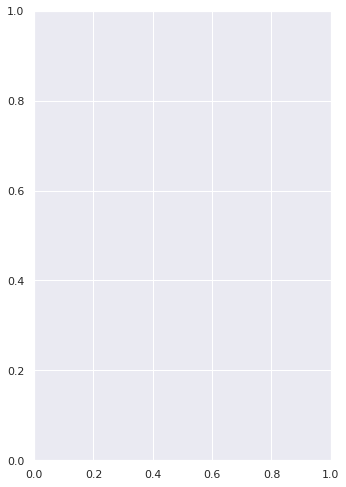

In [ ]:
# train data
plt.subplot(121)
plt.scatter(X_train, y_train)
plt.yscale('log')
plt.title("Train data")
for i, degree in enumerate(degrees):    
    plt.scatter(X_train, y_train_pred[:, i], s=15, label=str(degree))
    plt.legend(loc='upper left')
    
# test data
plt.subplot(122)
plt.scatter(X_test, y_test)
plt.yscale('log')
plt.title("Test data")
for i, degree in enumerate(degrees):    
    plt.scatter(X_test, y_test_pred[:, i], label=str(degree))
    plt.legend(loc='upper left')

**Decision Tree Regressor Modelling**

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor()

# Fit to training data
tree.fit(X_train,y_train)
print(tree)

# Predict
y_pred_tree = tree.predict(X_test)

# Score 
from sklearn import metrics
print('\nDecision Tree Regression Performance Metrics')
print('R^2=',metrics.explained_variance_score(y_test,y_pred_tree))
print('MAE:',metrics.mean_absolute_error(y_test,y_pred_tree))
print('MSE:',metrics.mean_squared_error(y_test,y_pred_tree))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test,y_pred_tree)))

**Random Forest Regressor**

In [ ]:
from sklearn.ensemble import RandomForestRegressor 

rforest = RandomForestRegressor(n_estimators = 20, n_jobs = -1)

# Fit to training data
rforest = rforest.fit(X_train,y_train)
print(rforest)

# Predict
y_pred_rforest = rforest.predict(X_test)

# Score
from sklearn import metrics
print('\nRandom Forest Regression Performance Metrics')
print('R^2 =',metrics.explained_variance_score(y_test,y_pred_rforest))
print('MAE',metrics.mean_absolute_error(y_test, y_pred_rforest))
print('MSE',metrics.mean_squared_error(y_test, y_pred_rforest))
print('RMSE',np.sqrt(metrics.mean_squared_error(y_test, y_pred_rforest)))

In [ ]:
from sklearn import neighbors
from math import sqrt

In [ ]:
# scaling features
scaler = MinMaxScaler(feature_range=(0, 1))

x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)

x_test_scaled = scaler.fit_transform(x_test)
x_test = pd.DataFrame(x_test_scaled)